## Purpose
Purpose of this notebook is to quickly train a image classifier that is able to distinguish between images of cats and dogs and achieve some acceptable degree of performance (a binary classification problem). Accuracy will be used to evaluate the performance and we'll train a simple CNN to classify the images.

## Libraries

In [162]:
import os
from utils import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Dataset preparation
The image data we're going to use is [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset available on [Kaggle](https://www.kaggle.com/) which contain 25,000 images of dogs and cats. You may need a Kaggle account to download the dataset on your local machine. The training set and test set  will be stored under ```datasets/train``` and ```datasets/test1``` subdirectories respectively.

In [109]:
TRAIN_DIR = 'datasets/train/'
TEST_DIR = 'datasets/test1'
print("Number of training images: {}".format(len(os.listdir(TRAIN_DIR))))
print("Number of test images: {}".format(len(os.listdir(TEST_DIR))))

Number of training images: 25000
Number of test images: 12500


### Load the dataset and resize the images
The dataset will include two parts:
- X: the actual images transformed to ndarray
- y: corresponding labels, where ```label = 0``` for dog images and ```label = 1``` for cat images.

Notice that there are 25,000 images in total available for training, but we will just use a subset of it like 5,000 images to speed up training phase. Also resize the images' height and width to 300.

In [112]:
dataset_size = 5000

In [110]:
X, y = load_image_dataset(dataset_size=dataset_size, size=(300, 300))
print(X.shape, y.shape)

(5000, 300, 300, 3) (5000, 1)


### Inspect images in the dataset

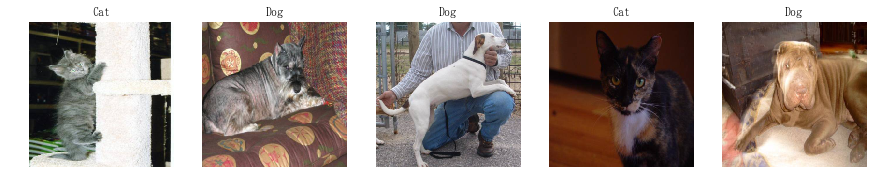

In [163]:
num_samples = 5
show_images_horizontally(X[:num_samples], y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})

### Build training / validation set
It's a good practice to make a subset of dataset as validation set and tuning our models before actually test their performance on the test set. Because the order of images in the dataset are already randomized (by randomly pick images in the folder), we can just separate the dataset into training set / validation set in the ratio of (0.7, 0.3).

In [164]:
train_set_ratio = 0.7
idx = int(dataset_size * train_set_ratio)
train_X, train_y, valid_X, valid_y = X[:idx], y[:idx], X[idx:], y[idx:]
del X, y # tips to save memory

### Data preprocessing

normalization
data augmentation

## Build model

### Computation graph

### Train the model